In [1]:
# https://www.youtube.com/watch?v=CSpsB4_-5WQ
# https://github.com/dredwardhyde/Seq2Seq-Chatbot-English/blob/master/chatbot_big.py

In [2]:
!pip install underthesea

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from underthesea import word_tokenize 

from keras import Input, Model
from keras.layers import Embedding, LSTM, Dense
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings("ignore")

In [4]:
# load data
df = pd.read_csv('../input/chatbot-data/chatbot-data.csv', usecols=[1,2])
df

,user_a,user_b
0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,Có crush ai không,Có 1 bạn cùng lớp
2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,Có hay nói chuyện không,Hay nhắn tin messenger
4,Bạn kia có bắt chuyện trước không,Có đôi khi
...,...,...
7389,Uầy vậy anh em mình có nên đi thể dục thể thao...,Vậy mày định rủ tao đi tập gì.
7390,Tao thấy bộ môn đó khá được ưa chuộng và còn n...,Mày xem các dân tổ đua xe nhiều quá nên ảo rồi...
7391,Đùa tí thôi tao tính rủ mày đi học võ bro.,Được nè. Tao khá thích taekwondo nhe.
7392,Tao sẽ học lên đai đen để về sút vào mấy thằng...,Oke mày là nhất :))


In [5]:
# lấy ra Questions và Answers
data_questions = df['user_a'].values
data_answers = df['user_b'].values

In [6]:
# hàm để xóa các ký tự đặc biệt
def clean_text(sent):
    return re.sub(r'[!“”"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', sent)

# hàm để chuyển Word Segmentation cho tiếng Việt
def clean_and_word_segmentation(sent):
    return word_tokenize(clean_text(sent.lower()), format='text')

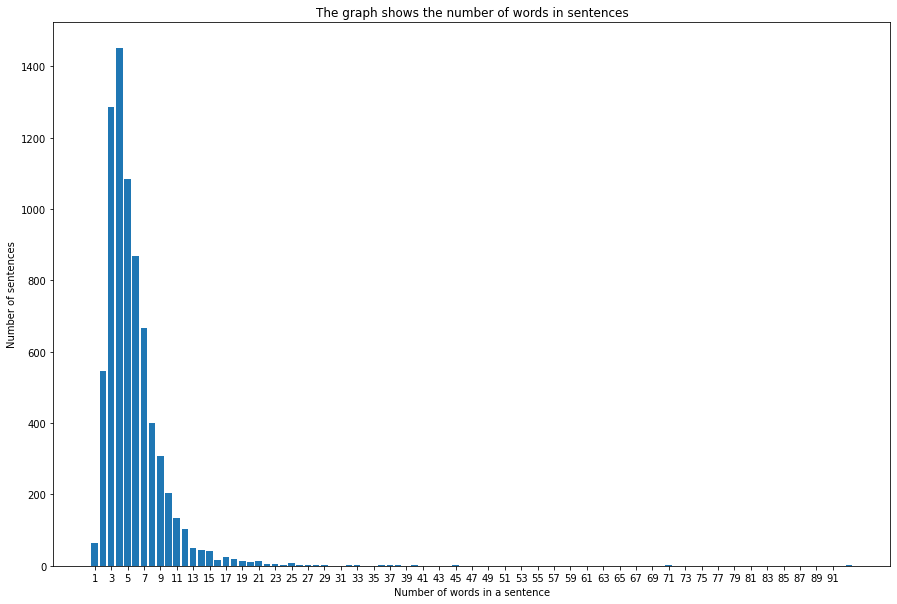

In [7]:
# vẽ biểu đồ thể hiện trực quan số lượng từ trong các questions
count_words_ques = [len(clean_text(ques).split()) for ques in data_questions]
counter_words_ques = Counter(count_words_ques)

list_count_word = []
list_count_sent = []
for i in counter_words_ques.items():
    #print(i)
    list_count_word.append(i[0])
    list_count_sent.append(i[1])
    
# ========== draw ========== #
plt.figure(figsize=(15,10))
plt.bar(list_count_word,list_count_sent)
plt.title('The graph shows the number of words in sentences')
plt.xlabel('Number of words in a sentence')
plt.ylabel('Number of sentences')
plt.xticks(range(min(list_count_word), max(list_count_word),2))
plt.show()

In [8]:
len(count_words_ques), len(data_questions)

(7394, 7394)

In [9]:
# loại bỏ những câu có số lượng từ > 15 từ
sorted_ques = []
sorted_ans = []
for i,count in enumerate(count_words_ques):
    if count <= 15:
        sorted_ques.append(data_questions[i])
        sorted_ans.append(data_answers[i])
        
print('len sorted_ques:', len(sorted_ques))
print('len sorted_ans:', len(sorted_ans))
sorted_ques[:2], sorted_ans[:2]

len sorted_ques: 7256
len sorted_ans: 7256


(['Thích mẫu người nào', 'Có crush ai không'],
 ['Dễ thương, tóc dài, da trắng', 'Có 1 bạn cùng lớp'])

In [10]:
# làm sạch và Word Segmentation cho sorted_ques và sorted_ans
questions = [clean_and_word_segmentation(ques) for ques in sorted_ques]
answers = ['<START> '+ clean_and_word_segmentation(answ) + ' <END>' for answ in sorted_ans]

questions[:2], answers[:2]

(['thích mẫu người nào', 'có crush ai không'],
 ['<START> dễ_thương tóc dài da trắng <END>',
  '<START> có 1 bạn cùng lớp <END>'])

In [11]:
# tokenize cho questions và answers
tokenizer = Tokenizer(filters='', lower=False)  # filters='' do dữ liệu đã được làm sạch và giữ lại word segmention
tokenizer.fit_on_texts(questions + answers)

# for word_index in tokenizer.word_index.items():
#     print(word_index)

In [12]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size : {VOCAB_SIZE}')

Vocabulary size : 4384


In [13]:
# encoder
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = 15
encoder_inp = pad_sequences(tokenized_questions,maxlen=maxlen_questions,padding='post')

print(encoder_inp.shape)
print(questions[0])
print(tokenized_questions[0])
print(encoder_inp[0])

(7256, 15)
thích mẫu người nào
[12, 294, 35, 13]
[ 12 294  35  13   0   0   0   0   0   0   0   0   0   0   0]


In [14]:
# decoder
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = np.max([len(x) for x in tokenized_answers])
decoder_inp = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

print(decoder_inp.shape)
print(answers[0])
print(tokenized_answers[0])
print(decoder_inp[0])

(7256, 43)
<START> dễ_thương tóc dài da trắng <END>
[1, 341, 1138, 454, 2112, 620, 2]
[   1  341 1138  454 2112  620    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [15]:
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
    
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_final_output = to_categorical(padded_answers, VOCAB_SIZE)

print(decoder_final_output.shape)
print(tokenized_answers[0])
print(padded_answers[0])
print(decoder_final_output[0])

(7256, 43, 4384)
[341, 1138, 454, 2112, 620, 2]
[ 341 1138  454 2112  620    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [16]:
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
_, state_h, state_c = LSTM(200, return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(200, return_state=True, return_sequences=True)

dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE, activation='softmax')
output = dec_dense(dec_outputs)

2022-05-19 04:06:07.859245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 04:06:07.867505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 04:06:07.868272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 04:06:07.869349: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    876800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    876800      input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
model.fit([encoder_inp, decoder_inp],
           decoder_final_output,
           batch_size=100,
           epochs=300)
model.save('sequence2sequence_lstm.h5')

2022-05-19 04:06:10.587041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5471372288 exceeds 10% of free system memory.
2022-05-19 04:06:16.880926: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5471372288 exceeds 10% of free system memory.
2022-05-19 04:06:20.833863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-05-19 04:06:26.886835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - 12s 64ms/step - loss: 0.6905
Epoch 2/300
73/73 [==============================] - 5s 62ms/step - loss: 0.5895
Epoch 3/300
73/73 [==============================] - 5s 71ms/step - loss: 0.5701
Epoch 4/300
73/73 [==============================] - 5s 66ms/step - loss: 0.5570
Epoch 5/300
73/73 [==============================] - 4s 61ms/step - loss: 0.5440
Epoch 6/300
73/73 [==============================] - 5s 64ms/step - loss: 0.5303
Epoch 7/300
73/73 [==============================] - 5s 62ms/step - loss: 0.5172
Epoch 8/300
73/73 [==============================] - 5s 65ms/step - loss: 0.5049
Epoch 9/300
73/73 [==============================] - 5s 62ms/step - loss: 0.4928
Epoch 10/300
73/73 [==============================] - 5s 69ms/step - loss: 0.4812
Epoch 11/300
73/73 [==============================] - 5s 66ms/step - loss: 0.4695
Epoch 12/300
73/73 [==============================] - 4s 61ms/step - loss: 0.4581
Epoch 13/300
73/73 [================

In [19]:
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                            initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs = [dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

def str_to_tokens(sentence):
    #words = sentence.lower().split()
    words = clean_and_word_segmentation(sentence).split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word)
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list], maxlen=maxlen_questions,padding='post')

enc_model, dec_model = make_inference_models()

Inference decoder:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    876800      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
_________________________________________________________________________

In [20]:
def chatbot():
    print('Bot: Xin chào!')
    
    while True:
        input_question = input('Question: ')
    
        if input_question == 'bye':
            print('Bot answer: bye')
            break
        states_values = enc_model.predict(str_to_tokens(input_question))
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = tokenizer.word_index['<START>']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition:
            dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values)
            sampled_word_index = np.argmax(dec_outputs[0,-1, :])
            sampled_word = None
            for word, index in tokenizer.word_index.items():
                if sampled_word_index == index:
                    if word != '<END>':
                        decoded_translation += f'{word} '
                    sampled_word = word

            if sampled_word == '<END>' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True
            empty_target_seq = np.zeros((1,1))
            empty_target_seq[0,0] = sampled_word_index
            states_values = [h,c]

        print('Bot answer:', decoded_translation, '\n')

In [21]:
# chat with bot
chatbot()

Bot: Xin chào!


Question:  bạn học ngành gì


Bot answer: mình học khoa cntt  



Question:  bạn có người yêu chưa


Bot answer: chưa có nha mình đang còn sợ ế đây này  



Question:  bạn có hay đi xem phim không


Bot answer: mình hay đi xem phim ở đây cũng hay nghe nhạc  



Question:  bạn nghe nhạc gì


Bot answer: cafe  



Question:  bye


Bot answer: bye
